In [45]:
import os 
import numpy as np
import h5py as h5
import nrrd
import fnmatch
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'cividis'

from skimage.measure import label

In [2]:
def readH5(file_path,**kwargs):
    """
    generic function to read a h5 file with one 
    subgroup elements by given filepath in a Dictonary 
    """

    import h5py as h5
    
    out = {}

    with h5.File(file_path, 'r') as f:

        for key in f.keys():

            if isinstance(f[key],h5.Group):
                out[key] = {}
                for sub_key in f[key]:
                    out[key][sub_key] = f[key][sub_key][...]
            else:
                out[key] = f[key][:]
        f.close()
    return out

In [81]:
pred_path   = "../predict/200_10-layer_00_1_predictions.h5"
vol_path    = "/Volumes/warm_archiv/3dseg/data/BIIAX/200_10-layer/volumes/00/rand_subvolume/200_10-layer_00_1.h5"

assert os.path.exists(pred_path) and os.path.exists

In [82]:

pred    = readH5(pred_path)
vol     = readH5(vol_path)

data= {}


for key, item in pred.items():
    data[key] = item
    print(key,item.shape)
    print(key,item.dtype)

for key, item in vol.items():
    data[key] = item




predictions (500, 256, 256)
predictions uint8


In [83]:
for key, item in data.items():
    if isinstance(item, dict):
        print(key)
        for subkey, subitems in item.items():
            print(subkey,subitems.shape,subitems.dtype,subitems)
    else:
        print(key,item.shape,item.dtype)

predictions (500, 256, 256) uint8
raw (500, 256, 256) uint16
volume_data
Datatype () object b'uint16'
HistogramUpToDate () bool True
Max () int64 65535
Min () int64 0
Offset () float64 403.435
Origin (3,) int64 [   0 1664 1344]
Scale () float64 11.4197
SizeX () int64 2200
SizeY () int64 2200
SizeZ () int64 500
UsedBits () int64 16
VoxelSizeX () float64 0.020618
VoxelSizeY () float64 0.020618
VoxelSizeZ () float64 0.020618


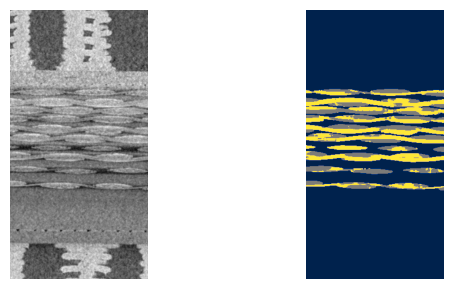

In [84]:
n =2
fig, axs = plt.subplots(1,n,figsize=(n*3.5,3.5))

axs = axs.flatten()
for ax in axs: ax.axis("off")

slice = 30

axs[0].imshow(data["raw"][:,:,slice],cmap="grey")
axs[1].imshow(data["predictions"][:,:,slice])

In [85]:
obj_ids = np.unique(data["predictions"])

print(len(obj_ids))

obj_ids = obj_ids[0:]
data["masks"] = data["predictions"] == obj_ids[:, None, None, None]

for key, item in data.items():
    if isinstance(item, dict):
        print(key,":")
        for subkey, subitems in item.items():
            print("\t",subkey,subitems.shape,subitems.dtype,subitems)
    else:
        print(key,item.shape,item.dtype)


3
predictions (500, 256, 256) uint8
raw (500, 256, 256) uint16
volume_data :
	 Datatype () object b'uint16'
	 HistogramUpToDate () bool True
	 Max () int64 65535
	 Min () int64 0
	 Offset () float64 403.435
	 Origin (3,) int64 [   0 1664 1344]
	 Scale () float64 11.4197
	 SizeX () int64 2200
	 SizeY () int64 2200
	 SizeZ () int64 500
	 UsedBits () int64 16
	 VoxelSizeX () float64 0.020618
	 VoxelSizeY () float64 0.020618
	 VoxelSizeZ () float64 0.020618
masks (3, 500, 256, 256) bool


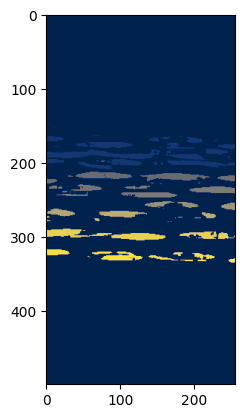

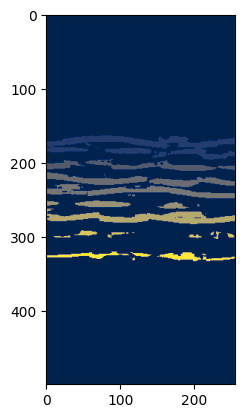

int16


In [86]:
mask = data["masks"][1]

plt.imshow(mask[:,:,slice])

labels = np.zeros((2,*data["raw"].shape))


for cls in range(1,data["masks"].shape[0]):
    labels[cls-1] = label(data["masks"][cls,::],connectivity=2)
    plt.imshow(labels[cls-1,:,:,slice])
    plt.show()

data["labels"] = labels.astype(np.int16)

print(data["labels"].dtype)

In [52]:
data["masks"].shape[0]

3

In [31]:
def create_nrrd_header(size, spacing,space_origin, data_type='float', space='left-posterior-superior'):
    header = {
        'type': data_type,
        'dimension': len(size),
        'space dimension': len(size),
        'sizes': size,
        'space': space,
        'space origin': space_origin
    }

    if len(spacing) == len(size):
        header['space directions'] = np.diag(spacing).tolist()
        header['kinds'] = ['domain'] * len(size)

    header.update({
        'endian': 'little',
        'encoding': 'raw',
    })

    return header

In [32]:
def numpy_dtype_to_nrrd_dtype(dtype):
    """
    Convert NumPy dtype to NRRD dtype string.

    Parameters:
    - dtype: NumPy dtype object

    Returns:
    - NRRD dtype string
    """
    dtype_mapping = {
        np.uint8: 'uint8',
        np.uint16: 'uint16',
        np.uint32: 'uint32',
        np.uint64: 'uint64',
        np.int8: 'int8',
        np.int16: 'int16',
        np.int32: 'int32',
        np.int64: 'int64',
        np.float16: 'float16',
        np.float32: 'float32',
        np.float64: 'float64',
    }

    return dtype_mapping.get(dtype, 'unknown')

In [76]:
data_type = data["raw"].dtype
data_type_seg = data["labels"].dtype
size = data["raw"].shape
spacing = ( data["volume_data"]["VoxelSizeZ"],
            data["volume_data"]["VoxelSizeY"],
            data["volume_data"]["VoxelSizeX"]
            )
space_origin = data["volume_data"]["Origin"]*spacing
header = create_nrrd_header(size, spacing, space_origin, data_type)
header_seg = create_nrrd_header(size, spacing, space_origin, data_type_seg)
fileout = os.path.splitext(os.path.basename(vol_path))[0] 
print(fileout,header_seg)

160_10-layer_00_1 {'type': dtype('int16'), 'dimension': 3, 'space dimension': 3, 'sizes': (500, 256, 256), 'space': 'left-posterior-superior', 'space origin': array([ 0.      , 31.669248, 40.906112]), 'space directions': [[0.020618, 0.0, 0.0], [0.0, 0.020618, 0.0], [0.0, 0.0, 0.020618]], 'kinds': ['domain', 'domain', 'domain'], 'endian': 'little', 'encoding': 'raw'}


In [77]:
nrrd.write(os.path.join(fileout + ".vol"+ ".nrrd"), data["raw"],header=header)
nrrd.write(os.path.join(fileout + ".seg"+ ".nrrd"), data["labels"][0,::],header=header_seg)

In [4]:
found_first_item = False
for root, dirs, files in os.walk(src_path):

    for dir_name in dirs:
        # print(dir_name)
        if "rand_subvolume" in dir_name.lower():
            # print(dir_name)
            print(os.listdir(os.path.join(root,dir_name)))
            for file in fnmatch.filter(os.listdir(os.path.join(root,dir_name)),"*.h5"):
                
                print(os.path.join(root,dir_name,file))
                file_path = os.path.join(root,dir_name,file)

                data = readH5(file_path)

                data_type = data["raw"].dtype
                size = data["raw"].shape
                spacing = ( data["volume_data"]["VoxelSizeX"],
                            data["volume_data"]["VoxelSizeX"],
                            data["volume_data"]["VoxelSizeX"]
                            )

                space_origin = data["volume_data"]["Origin"]*spacing
                print(data_type,len(size),spacing,space_origin)


                header = create_nrrd_header(size, spacing, space_origin, data_type)
                fileout = os.path.splitext(file)[0]


                nrrd.write(os.path.join(root,dir_name,fileout + ".nrrd"), data["raw"],header=header)
                


                found_first_item = False
                
        if found_first_item:
            break
    if found_first_item:
            break        